In [1]:
from scipy.stats import gaussian_kde
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

# Aux Functions

In [ ]:
def plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title, metric='executed'):
    """ 
        Plot the average executed inventory.
        Note that 'action' or 'executed' can be plotted.
        With 'action', the plot will exceed 100%.
        Default is 'executed'.
    """

    actions = {}
    for i, run_name in enumerate(run_names):
        with open(f'data_wandb/dictionaries/{run_name}.pkl', 'rb') as f:
            dic = pickle.load(f)
        actions[run_labels[i]] = dic[metric]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ep_lengths = []
    for key, values in actions.items():
        inventory = np.zeros((nb_episodes, len(trader_times)))
        for i in range(nb_episodes):
            inventory[i][:len(values[i])] = values[i]
            if key == 'DDQN':
                ep_lengths.append(len(values[i])) 

        inventory = np.cumsum(inventory, axis=1) / initial_inventory
        mean_inventory = inventory.mean(axis=0)
        std_inventory = inventory.std(axis=0)

        # Plot mean curve
        ax1.plot(trader_times, mean_inventory, label=key)

        # Shaded area for ±1 std
        ax1.fill_between(trader_times,
                        mean_inventory - std_inventory,
                        mean_inventory + std_inventory,
                        alpha=0.3)
            

    ax1.set_ylabel('Executed Inventory (%)')
    ax1.set_title(f'{title}')
    ax1.grid(True)
    ax1.legend()

    trader_time_step = trader_times[1] - trader_times[0]
    ax2.hist(trader_time_step * np.array(ep_lengths), bins=30, density=True, label='DDQN')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Density')
    ax2.set_title(f'Episode Length Distribution')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    # plt.savefig(f'plots/inventory/{pdf_name}.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

In [19]:
def plot_is(run_names, run_labels, pdf_name, title, kde_only=True):

    final_is = {}

    for i, run_name in enumerate(run_names):
        with open(f'data_wandb/dictionaries/{run_name}.pkl', 'rb') as f:
            dic = pickle.load(f)
        final_is[run_labels[i]] = dic['final_is']

    plt.figure(figsize=(7, 5))

    maxi = max(
        max(np.abs(np.max(values)), np.abs(np.min(values)))
        for values in final_is.values()
    )
    x = np.linspace(-maxi, maxi, 1000)

    for key, values in final_is.items():
        print(f'Method {key}')
        print(f'Mean: {np.mean(values):.2f}, Std: {np.std(values):.2f} \n')
        kde = gaussian_kde(values)
        y_kde = kde(x)
        
        if not kde_only:
            plt.hist(values, bins=30, density=True, alpha=0.3, label=f'{key}')

        plt.plot(x, y_kde, label=f'{key}')

    plt.xlabel('Implementation Shortfall')
    plt.ylabel('Density')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f'plots/implementation_shortfall/{pdf_name}.pdf', bbox_inches='tight')
    plt.show()

# Plots

## glbpbi4x

Method DDQN
Mean: -1.30, Std: 2.34 

Method TWAP
Mean: 0.04, Std: 4.40 

Method Front Load
Mean: -1.30, Std: 2.34 

Method Best Volume
Mean: 0.23, Std: 3.53 



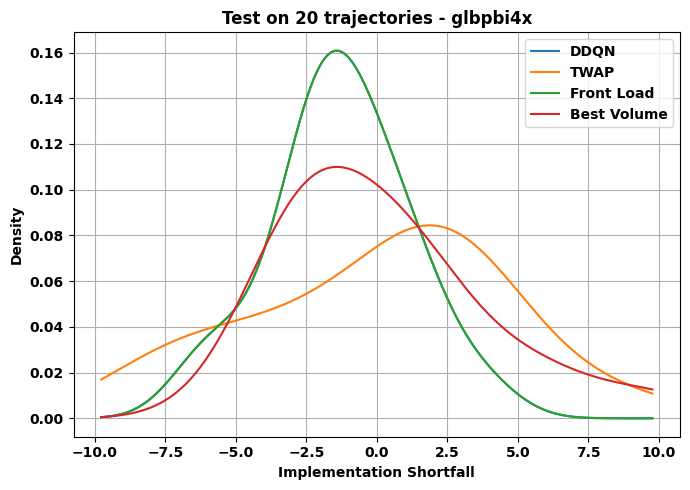

In [22]:
nb_episodes = 20
run_id = 'glbpbi4x'
types = ['ddqn', 'twap', 'front_load', 'best_volume']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'TWAP', 'Front Load', 'Best Volume']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

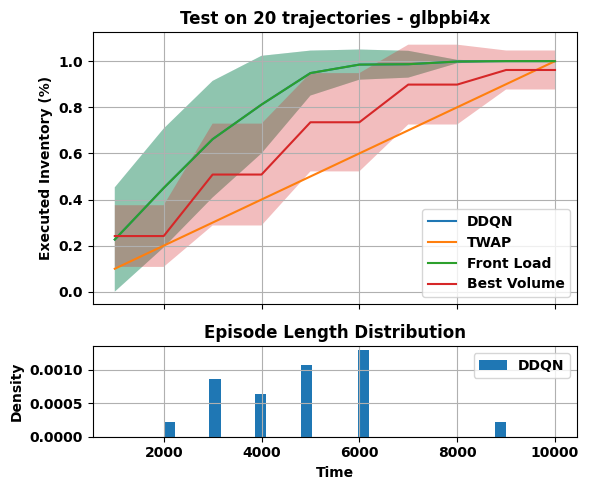

In [ ]:
initial_inventory = 30
nb_episodes = 20
th = 10000
ts = 1000
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = 'glbpbi4x'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'twap', 'front_load', 'best_volume']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'TWAP', 'Front Load', 'Best Volume']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

## unf4ls2t

Method DDQN
Mean: -0.25, Std: 3.27 

Method Front Load
Mean: -0.27, Std: 2.30 

Method Best Volume
Mean: -0.24, Std: 2.66 



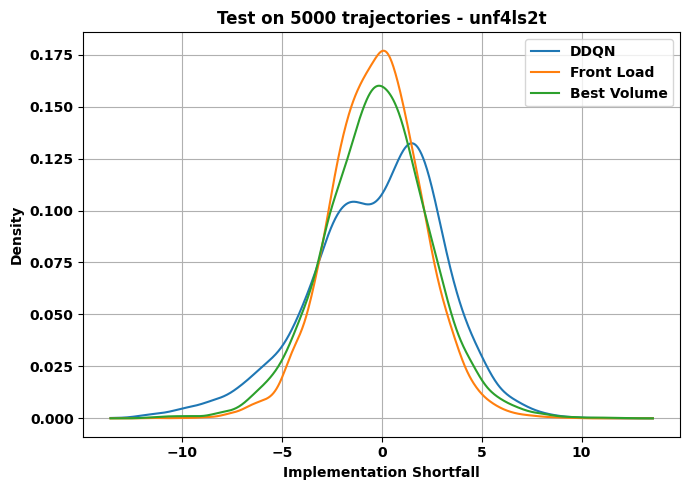

In [58]:
nb_episodes = 5000
run_id = 'unf4ls2t'
types = ['ddqn', 'front_load', 'best_volume']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

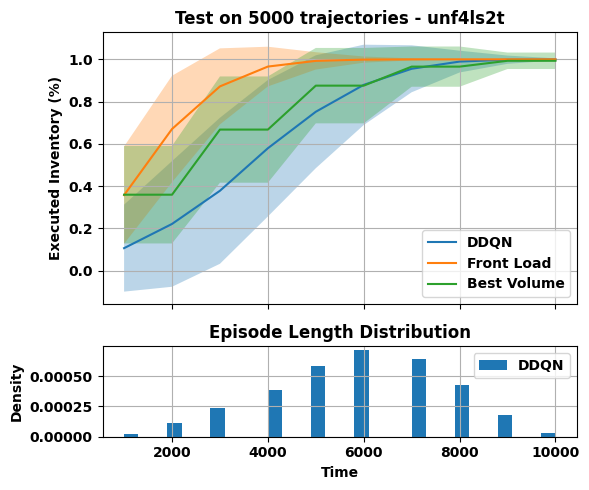

In [59]:
initial_inventory = 25
nb_episodes = 5000
th = 10000
ts = 1000
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = 'unf4ls2t'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'front_load', 'best_volume']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

## z84125v6

Method DDQN
Mean: -0.23, Std: 2.77 

Method Front Load
Mean: -0.27, Std: 2.30 

Method Best Volume
Mean: -0.24, Std: 2.66 



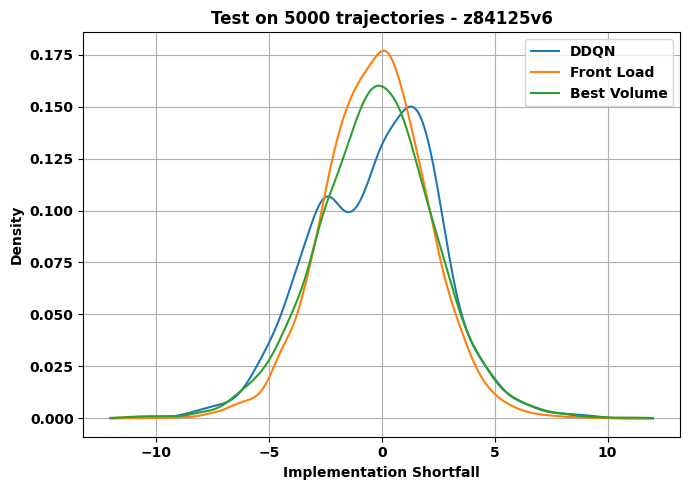

In [60]:
nb_episodes = 5000
run_id = 'z84125v6'
types = ['ddqn', 'front_load', 'best_volume']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

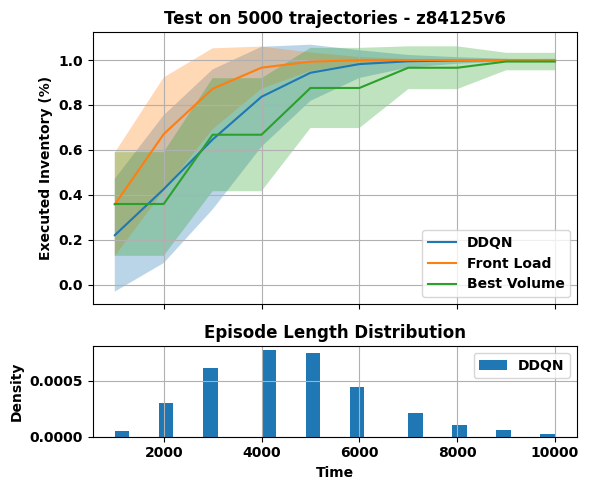

In [61]:
initial_inventory = 25
nb_episodes = 5000
th = 10000
ts = 1000
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = 'z84125v6'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'front_load', 'best_volume']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

## srr1gewe

Method DDQN
Mean: -0.26, Std: 2.34 

Method Front Load
Mean: -0.27, Std: 2.30 

Method Best Volume
Mean: -0.24, Std: 2.66 



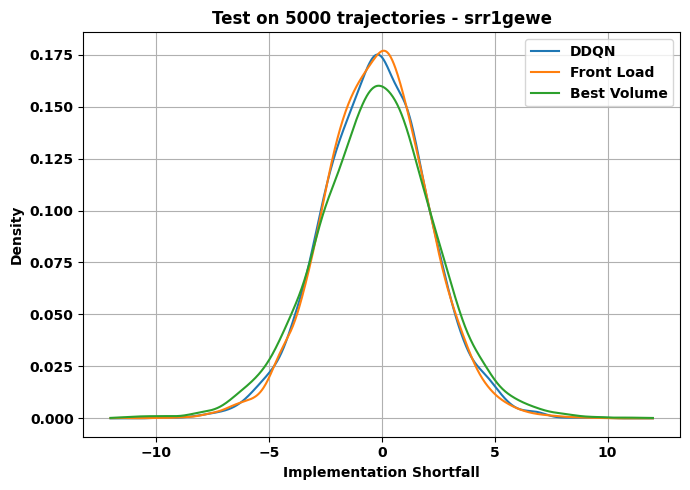

In [62]:
nb_episodes = 5000
run_id = 'srr1gewe'
types = ['ddqn', 'front_load', 'best_volume']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

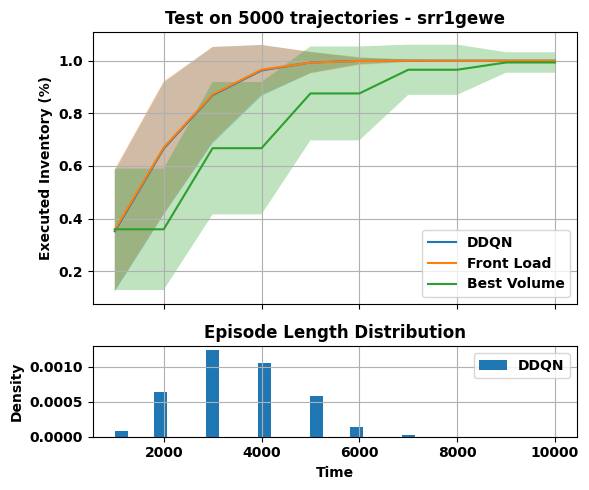

In [63]:
initial_inventory = 25
nb_episodes = 5000
th = 10000
ts = 1000
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = 'srr1gewe'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'front_load', 'best_volume']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

## 7t3fz3e6

Method DDQN
Mean: -9.55, Std: 4.56 

Method TWAP
Mean: -7.37, Std: 4.64 

Method Front Load
Mean: -9.53, Std: 4.53 

Method Best Volume
Mean: -6.16, Std: 3.94 

Method Best Volume 3
Mean: -2.73, Std: 2.33 



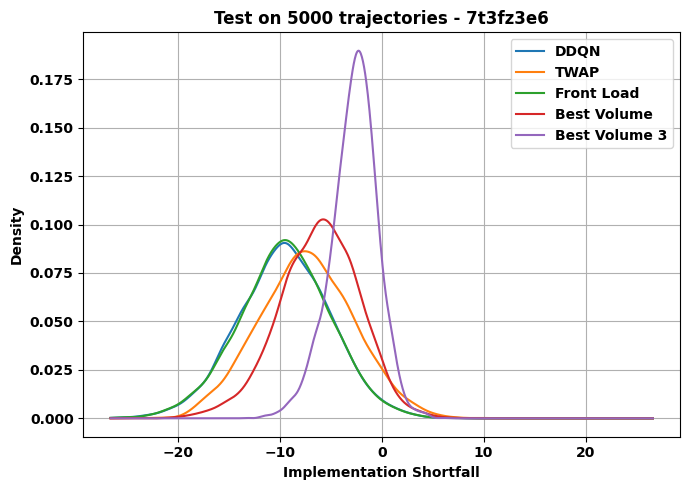

In [139]:
nb_episodes = 5000
run_id = '7t3fz3e6'
types = ['ddqn', 'twap', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'TWAP', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

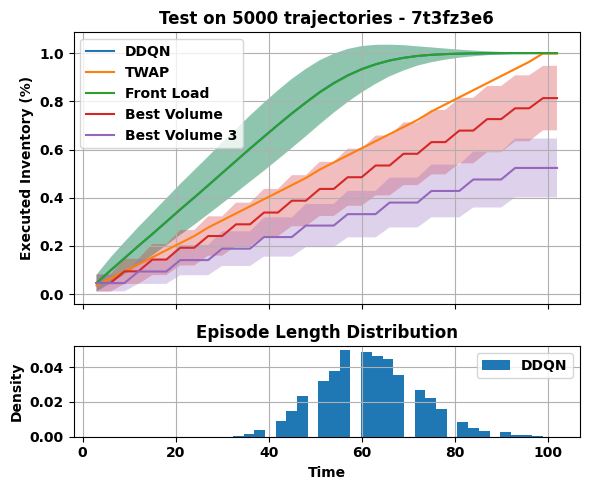

In [140]:
initial_inventory = 170
nb_episodes = 5000
th = 100
ts = 3
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = '7t3fz3e6'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'twap', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'TWAP', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

## 8kv6xa0w

Method DDQN
Mean: -2.69, Std: 1.61 

Method TWAP
Mean: -2.25, Std: 1.97 

Method Front Load
Mean: -2.75, Std: 1.59 

Method Best Volume
Mean: -2.61, Std: 1.85 

Method Best Volume 3
Mean: -2.20, Std: 1.84 



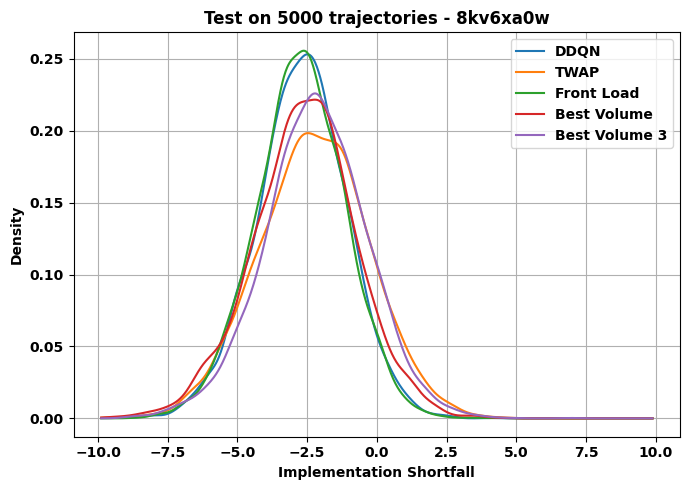

In [144]:
nb_episodes = 5000
run_id = '8kv6xa0w'
types = ['ddqn', 'twap', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'TWAP', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

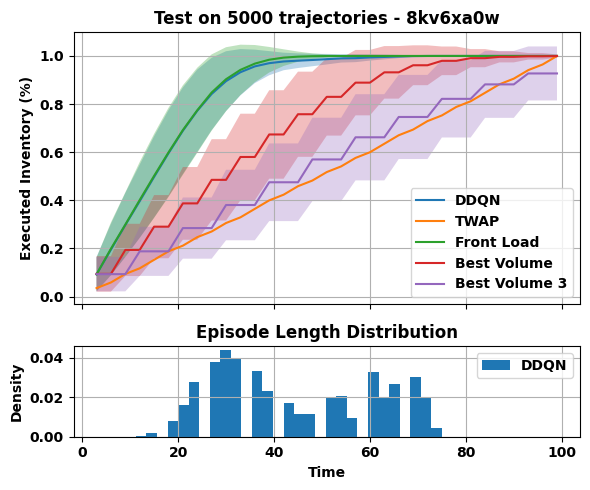

In [145]:
initial_inventory = 85
nb_episodes = 5000
th = 99
ts = 3
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = '8kv6xa0w'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'twap', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'TWAP', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

## iw54la4q

Method DDQN
Mean: -0.77, Std: 0.79 

Method Front Load
Mean: -0.84, Std: 0.58 

Method Best Volume
Mean: -0.79, Std: 0.65 

Method Best Volume 3
Mean: -0.77, Std: 0.71 



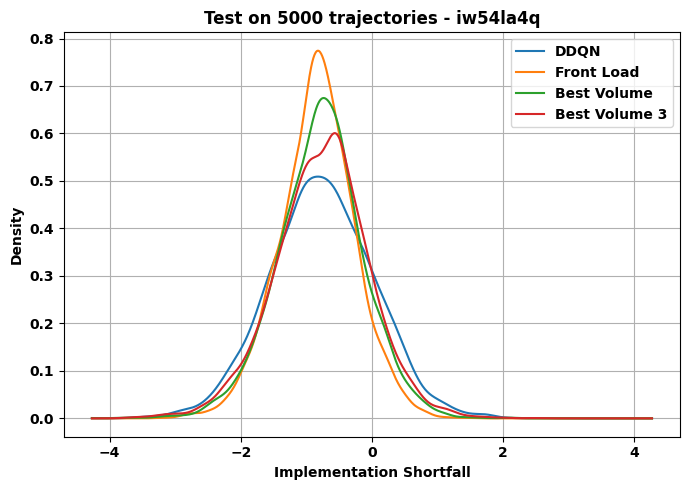

In [154]:
nb_episodes = 5000
run_id = 'iw54la4q'
types = ['ddqn','front_load', 'best_volume', 'best_volume_3']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

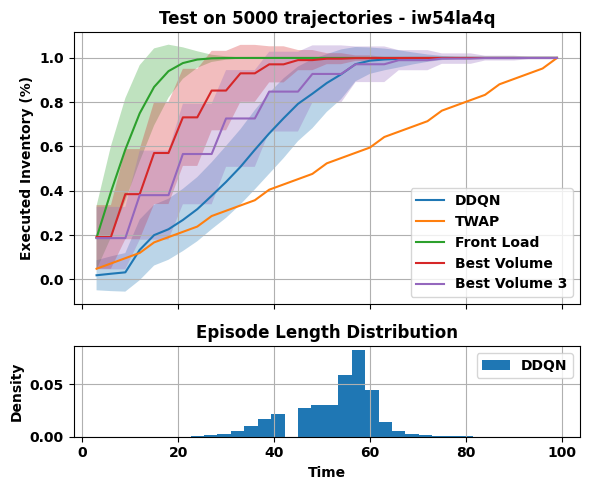

In [155]:
initial_inventory = 42
nb_episodes = 5000
th = 99
ts = 3
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = 'iw54la4q'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'twap', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'TWAP', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

## nlas29sb

Method DDQN
Mean: -0.84, Std: 0.58 

Method Front Load
Mean: -0.84, Std: 0.58 

Method Best Volume
Mean: -0.79, Std: 0.65 

Method Best Volume 3
Mean: -0.77, Std: 0.71 



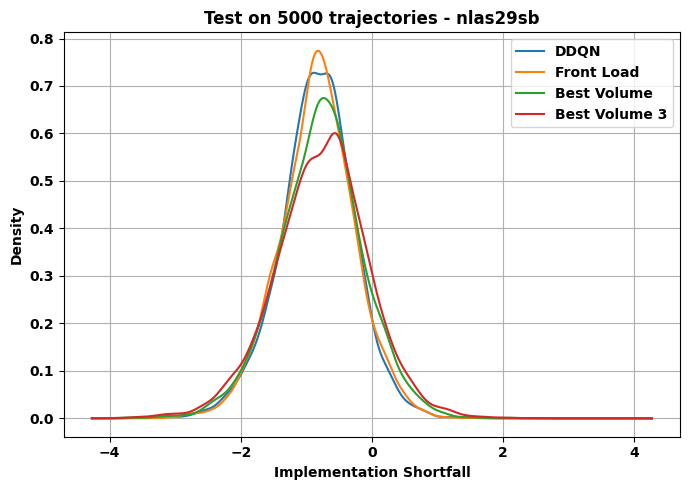

In [157]:
nb_episodes = 5000
run_id = 'nlas29sb'
types = ['ddqn','front_load', 'best_volume', 'best_volume_3']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

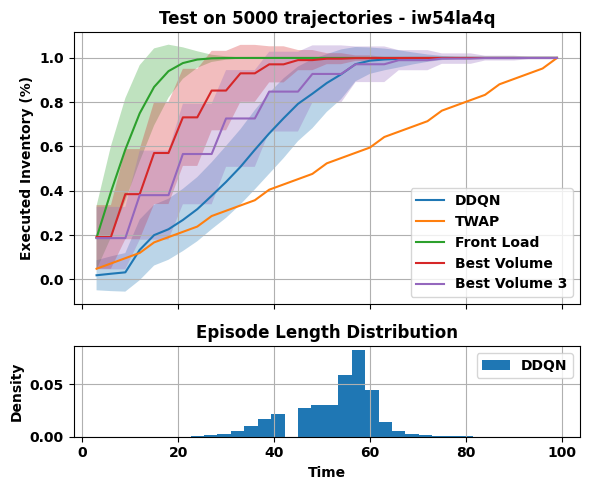

In [ ]:
initial_inventory = 42
nb_episodes = 5000
th = 99
ts = 3
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = 'nlas29sb'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'twap', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'TWAP', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

## chkjhxx7

Method DDQN
Mean: -0.80, Std: 0.63 

Method Front Load
Mean: -0.84, Std: 0.58 

Method Best Volume
Mean: -0.79, Std: 0.65 

Method Best Volume 3
Mean: -0.77, Std: 0.71 



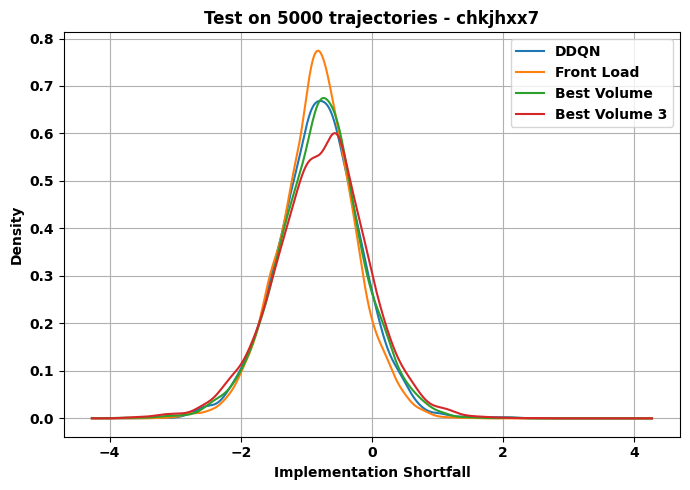

In [160]:
nb_episodes = 5000
run_id = 'chkjhxx7'
types = ['ddqn', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

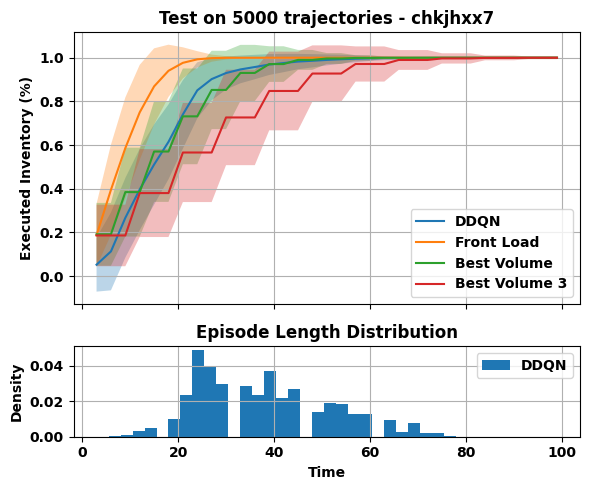

In [161]:
initial_inventory = 42
nb_episodes = 5000
th = 99
ts = 3
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = 'chkjhxx7'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

## rhfskp10

Method DDQN
Mean: -0.80, Std: 0.65 

Method Front Load
Mean: -0.84, Std: 0.58 

Method Best Volume
Mean: -0.79, Std: 0.65 

Method Best Volume 3
Mean: -0.77, Std: 0.71 



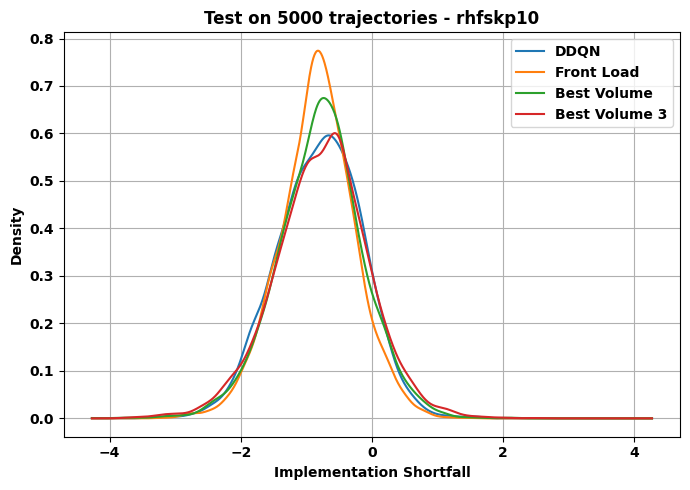

In [164]:
nb_episodes = 5000
run_id = 'rhfskp10'
types = ['ddqn', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

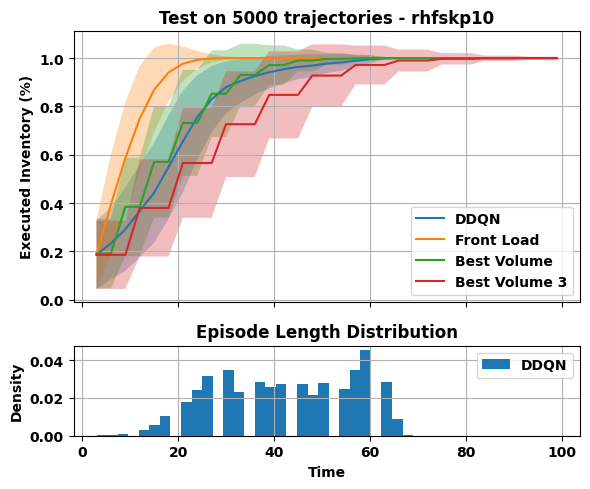

In [165]:
initial_inventory = 42
nb_episodes = 5000
th = 99
ts = 3
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = 'rhfskp10'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

## 0b48l22q

Method DDQN
Mean: -0.80, Std: 0.74 

Method Front Load
Mean: -0.84, Std: 0.58 

Method Best Volume
Mean: -0.79, Std: 0.65 

Method Best Volume 3
Mean: -0.77, Std: 0.71 



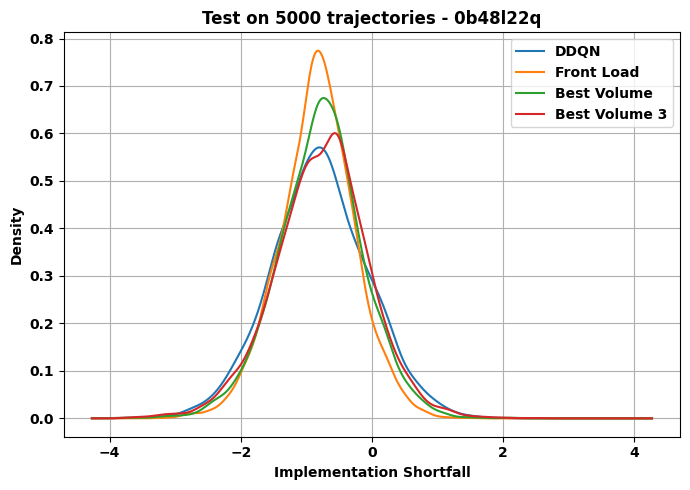

In [162]:
nb_episodes = 5000
run_id = '0b48l22q'
types = ['ddqn', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{type}_{run_id}' for type in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11_ddqns'
title = f'Test on {nb_episodes} trajectories - {run_id}'
plot_is(run_names, run_labels, pdf_name, title)

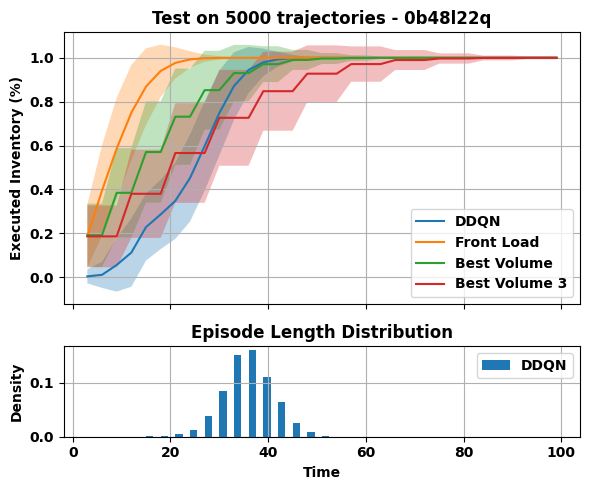

In [163]:
initial_inventory = 42
nb_episodes = 5000
th = 99
ts = 3
trader_times = np.arange(0, th + ts, ts) 
trader_times = trader_times[1:]

run_id = '0b48l22q'
run_ids = [run_id] 
run_names = [f'ddqn_{run_id}' for run_id in run_ids]
# run_names += ['twap_5ym1biox', 'back_load_5ym1biox', 'front_load_5ym1biox', 'front_load_1_5ym1biox']

types = ['ddqn', 'front_load', 'best_volume', 'best_volume_3']
run_names = [f'{tp}_{run_id}' for tp in types]
run_labels = ['DDQN', 'Front Load', 'Best Volume', 'Best Volume 3']
pdf_name = 's_11'
title = f'Test on {nb_episodes} trajectories - {run_id}' 
plot_inventory(initial_inventory, nb_episodes, trader_times, run_names, run_labels, pdf_name, title)

# Average Price Trajectories

FULL CODE: this is the code when the option saving memory is False and you have all the LOB. Just change the file names to import dictionary with pickle.

In [ ]:
T = 10000
trader_time_step = 1000
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

path = 'C:/Users/etoma/OneDrive - CentraleSupelec/OneDrive/Desktop/test_git_code/qrm_optimal_execution'
with open(f'{path}/data_wandb/dictionaries/best_volume_srr1gewe.pkl', 'rb') as f:
    dic = pickle.load(f)

lobs = dic['lob']
lengths = []
for key, lob in lobs.items():
    lengths.append(len(lob))

print('Statistics of the lengths of the LOBs:')
print('min', min(lengths), 'max', max(lengths), 'mean', np.mean(lengths), 'std', np.std(lengths))


mid_prices_time = np.full((len(lobs), len(trader_times)), np.nan)

length = min(lengths)
mid_prices = np.zeros((len(lobs), length))
volumes = []
q_ask1_vol = []
best_ask_vol = []
for i, (key, lob) in enumerate(lobs.items()):
    matched_rows = lob[lob['time'].isin(trader_times)]
    n = len(matched_rows)
    mid_prices_time[i][:n] = matched_rows['p_mid'].to_numpy()

    n = min(len(lob), length)
    mid_prices[i, :n] = lob.p_mid.values[:n]
    # # total ask volume
    # vols = list(lob[['q_ask1', 'q_ask2', 'q_ask3']].values.sum(axis=1))
    # volumes += vols
    # # q_ask1 volume
    # vols = list(lob['q_ask1'].values)
    # q_ask1_vol += vols
    # # best ask volume
    # vols = lob[['q_ask1', 'q_ask2', 'q_ask3']].to_numpy()
    # mask = vols != 0
    # first_nonzero_indices = mask.argmax(axis=1)
    # row_indices = np.arange(vols.shape[0])
    # best_ask_vol = np.where(
    #     mask.any(axis=1),
    #     vols[row_indices, first_nonzero_indices],
    #     0 )


executed = dic['executed']
execs = []
for key, value in executed.items():
    execs += value

plt.figure(figsize=(6, 4))
plt.plot(np.nanmean(mid_prices_time, axis=0), label='Mean Mid Price')
plt.title('Average Mid Price at Trader Times')

plt.figure(figsize=(6, 4))
plt.plot(mid_prices.mean(axis=0), label='Mean Mid Price')
plt.title('Average Mid Price')

plt.figure(figsize=(6, 4))
sns.kdeplot(volumes, fill=True, color='blue', alpha=0.7)
plt.title('Total Ask Volume Distribution')
print('Average total ask volume', np.mean(volumes))

plt.figure(figsize=(6, 4))
sns.kdeplot(q_ask1_vol, fill=True, color='blue', alpha=0.7)
plt.title('q_ask1 Volume Distribution')
print('Average q_ask1 volume', np.mean(q_ask1_vol))

plt.figure(figsize=(6, 4))
sns.kdeplot(best_ask_vol, fill=True, color='blue', alpha=0.7)
plt.title('Best Ask Volume Distribution')
print('Average best ask volume', np.mean(best_ask_vol))

plt.figure(figsize=(6, 4))
sns.kdeplot(execs, fill=True, color='blue', alpha=0.7)
plt.hist(execs, bins=50, alpha=0.7, color='blue')
plt.title('Executions')

## T = 10 000, TTS = 1000, Inv=25

In [85]:
name_run = 'srr1gewe'

### Best Volume mod 2

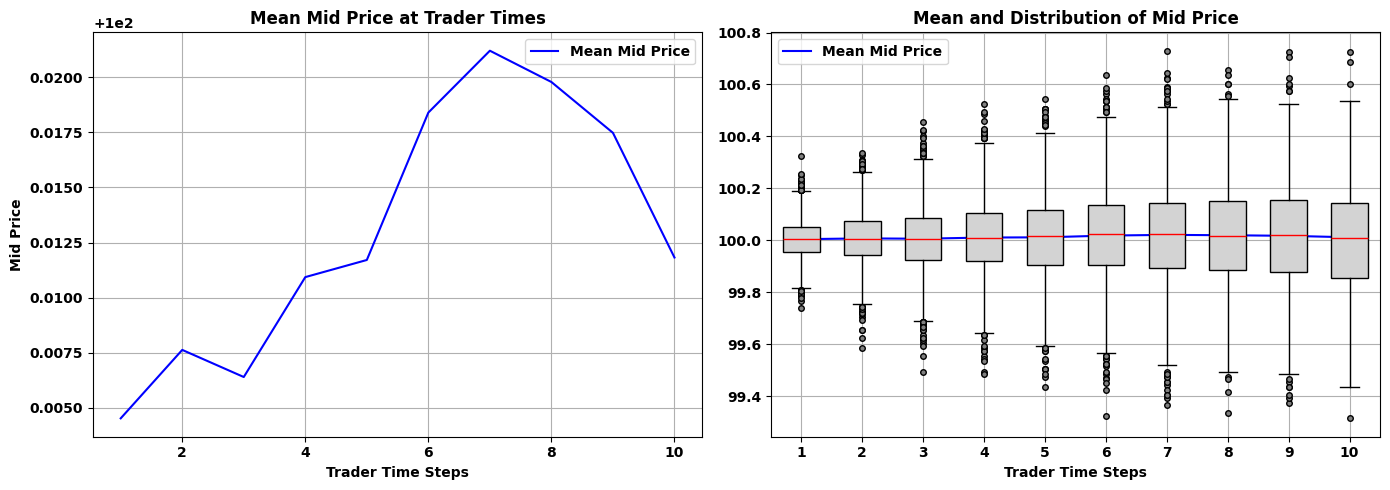

In [ ]:
T = 10000
trader_time_step = 1000
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/best_volume_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']

arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
x_vals = range(1, len(trader_times))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: mean mid price only
axs[0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0].set_title('Mean Mid Price at Trader Times')
axs[0].set_xlabel('Trader Time Steps')
axs[0].set_ylabel('Mid Price')
axs[0].grid()
axs[0].legend()

# Right plot: mean mid price + boxplots
axs[1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1].set_title('Mean and Distribution of Mid Price')
axs[1].set_xlabel('Trader Time Steps')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


## Front Load

C:\Users\etoma\AppData\Local\Temp\ipykernel_14672\2012177380.py:14: RuntimeWarning: Mean of empty slice
  mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)


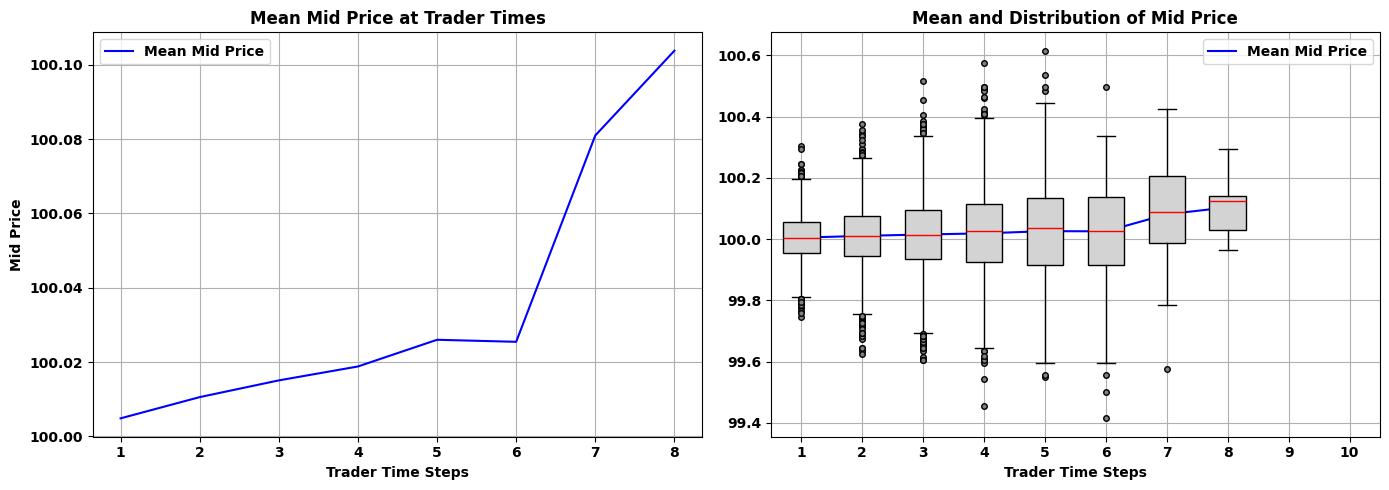

In [ ]:
T = 10000
trader_time_step = 1000
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/front_load_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']

arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
x_vals = range(1, len(trader_times))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: mean mid price only
axs[0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0].set_title('Mean Mid Price at Trader Times')
axs[0].set_xlabel('Trader Time Steps')
axs[0].set_ylabel('Mid Price')
axs[0].grid()
axs[0].legend()

# Right plot: mean mid price + boxplots
axs[1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1].set_title('Mean and Distribution of Mid Price')
axs[1].set_xlabel('Trader Time Steps')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


## T = 10 000, TTS = 1000, Inv=40

In [86]:
name_run = 'inv_40'

### Best Volume mod 2

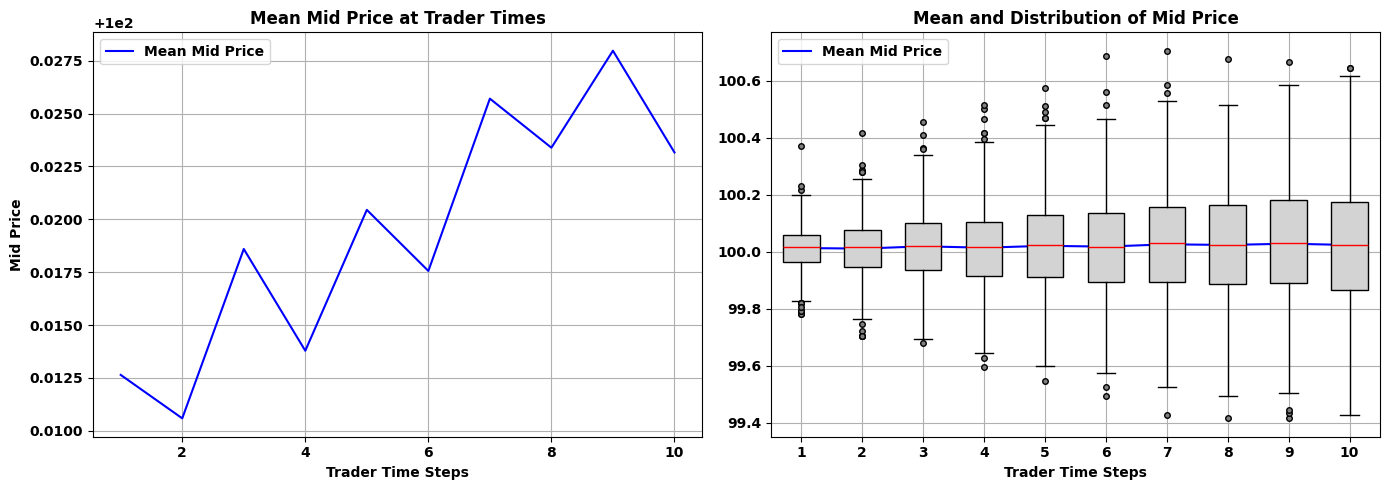

In [87]:
T = 10000
trader_time_step = 1000
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/best_volume_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']

arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
x_vals = range(1, len(trader_times))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: mean mid price only
axs[0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0].set_title('Mean Mid Price at Trader Times')
axs[0].set_xlabel('Trader Time Steps')
axs[0].set_ylabel('Mid Price')
axs[0].grid()
axs[0].legend()

# Right plot: mean mid price + boxplots
axs[1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1].set_title('Mean and Distribution of Mid Price')
axs[1].set_xlabel('Trader Time Steps')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


## Front Load

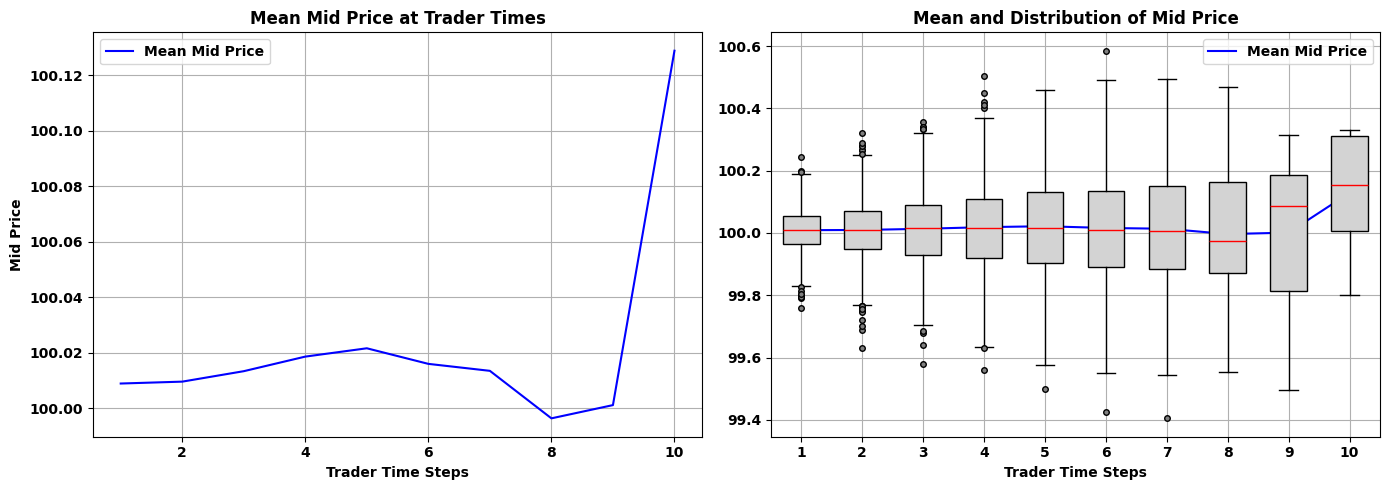

In [88]:
T = 10000
trader_time_step = 1000
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/front_load_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']

arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
x_vals = range(1, len(trader_times))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: mean mid price only
axs[0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0].set_title('Mean Mid Price at Trader Times')
axs[0].set_xlabel('Trader Time Steps')
axs[0].set_ylabel('Mid Price')
axs[0].grid()
axs[0].legend()

# Right plot: mean mid price + boxplots
axs[1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1].set_title('Mean and Distribution of Mid Price')
axs[1].set_xlabel('Trader Time Steps')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


## T = 1000, TTS = 100, Inv=1000

In [103]:
T = 1000
trader_time_step = 100
name_run = 'tts_100_inv_1000'

### Best Volume mod 2

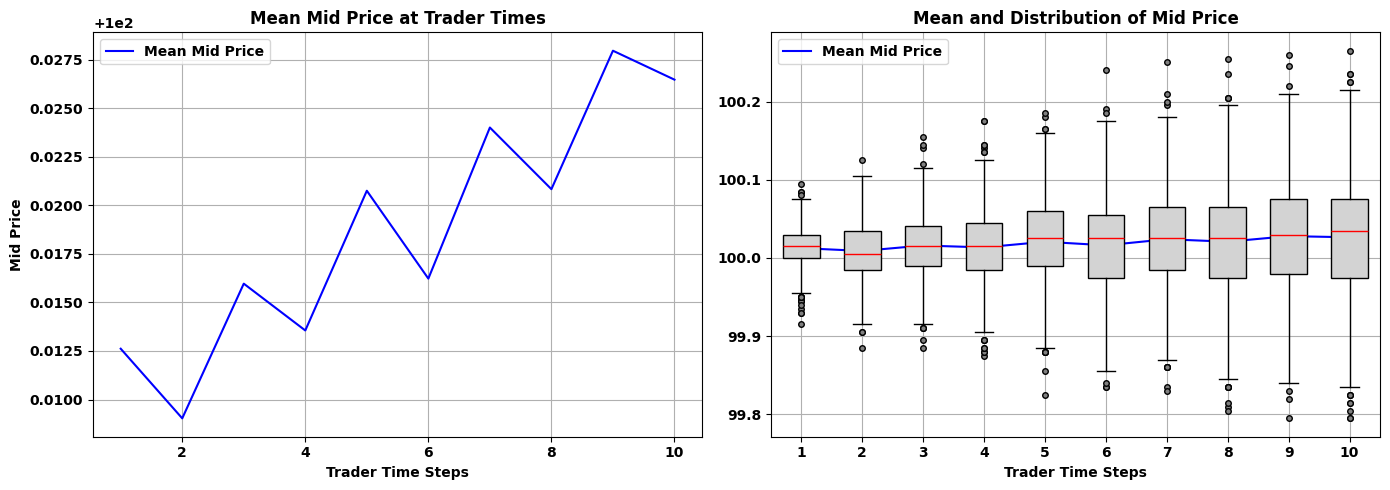

In [104]:
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/best_volume_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']

arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
x_vals = range(1, len(trader_times))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: mean mid price only
axs[0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0].set_title('Mean Mid Price at Trader Times')
axs[0].set_xlabel('Trader Time Steps')
axs[0].set_ylabel('Mid Price')
axs[0].grid()
axs[0].legend()

# Right plot: mean mid price + boxplots
axs[1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1].set_title('Mean and Distribution of Mid Price')
axs[1].set_xlabel('Trader Time Steps')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


## Front Load

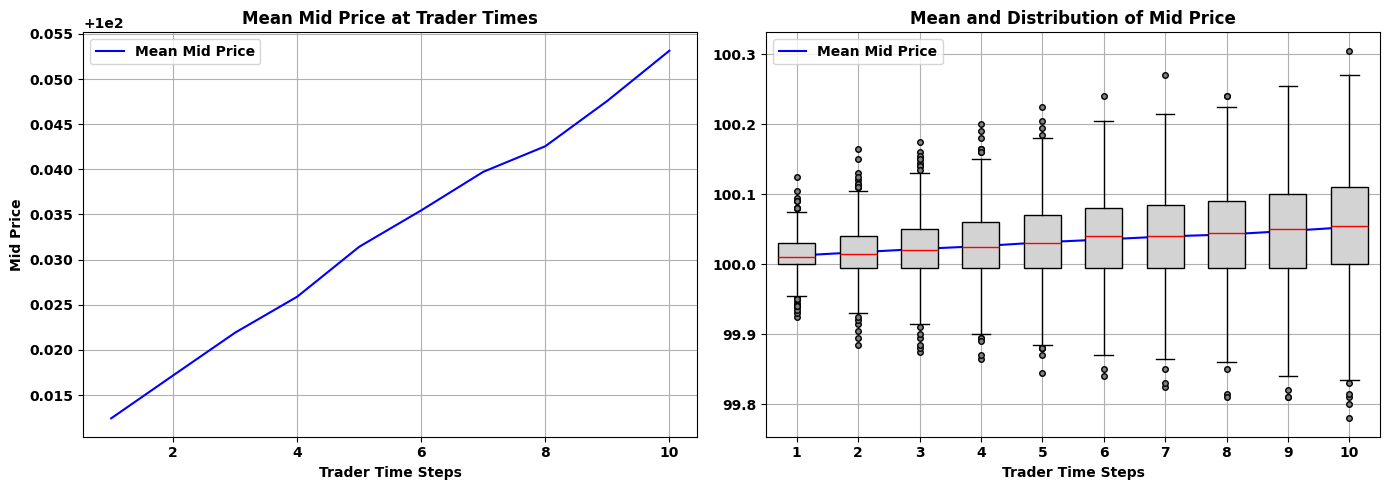

In [105]:
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/front_load_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']

arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
x_vals = range(1, len(trader_times))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: mean mid price only
axs[0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0].set_title('Mean Mid Price at Trader Times')
axs[0].set_xlabel('Trader Time Steps')
axs[0].set_ylabel('Mid Price')
axs[0].grid()
axs[0].legend()

# Right plot: mean mid price + boxplots
axs[1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1].set_title('Mean and Distribution of Mid Price')
axs[1].set_xlabel('Trader Time Steps')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


## T = 1000, TTS = 50, Inv=1000

In [106]:
T = 1000
trader_time_step = 50
name_run = 'tts_50_inv_1000'

### Best Volume mod 2

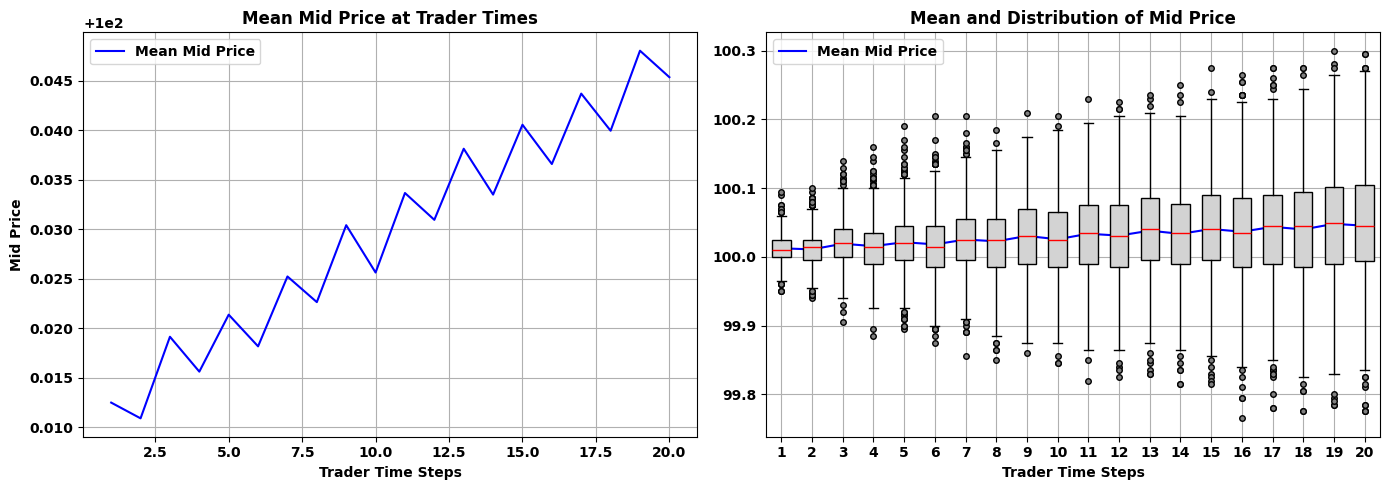

In [107]:
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/best_volume_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']

arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
x_vals = range(1, len(trader_times))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: mean mid price only
axs[0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0].set_title('Mean Mid Price at Trader Times')
axs[0].set_xlabel('Trader Time Steps')
axs[0].set_ylabel('Mid Price')
axs[0].grid()
axs[0].legend()

# Right plot: mean mid price + boxplots
axs[1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1].set_title('Mean and Distribution of Mid Price')
axs[1].set_xlabel('Trader Time Steps')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


## Front Load

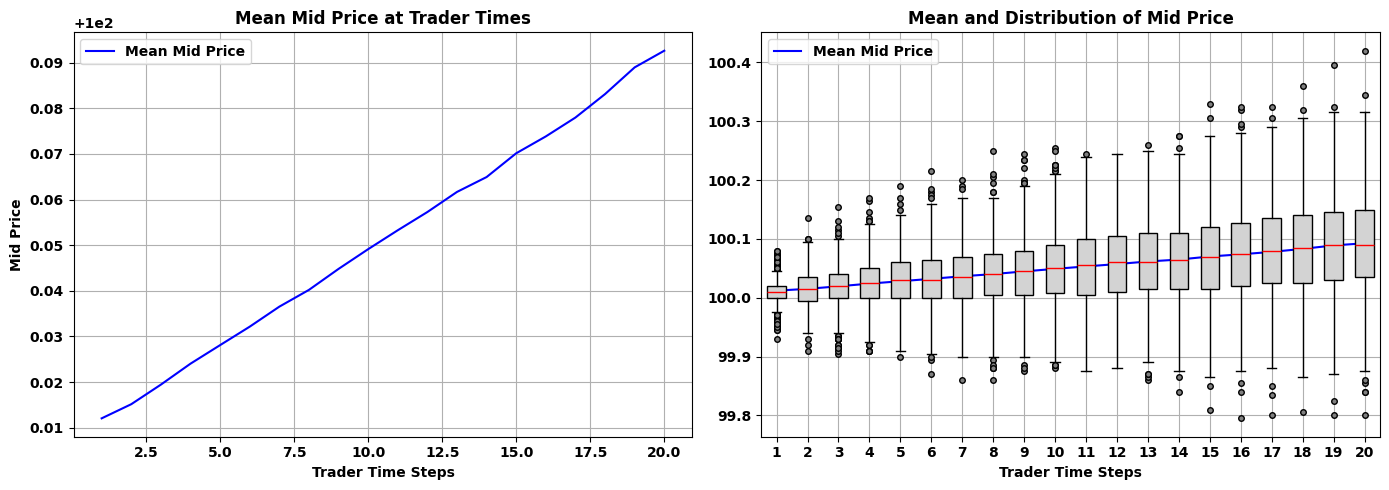

In [109]:
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/front_load_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']

arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
x_vals = range(1, len(trader_times))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: mean mid price only
axs[0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0].set_title('Mean Mid Price at Trader Times')
axs[0].set_xlabel('Trader Time Steps')
axs[0].set_ylabel('Mid Price')
axs[0].grid()
axs[0].legend()

# Right plot: mean mid price + boxplots
axs[1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1].set_title('Mean and Distribution of Mid Price')
axs[1].set_xlabel('Trader Time Steps')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


## T = 1000, TTS = 25, Inv=1000

In [110]:
T = 1000
trader_time_step = 25
name_run = 'tts_25_inv_1000'

### Best Volume mod 2

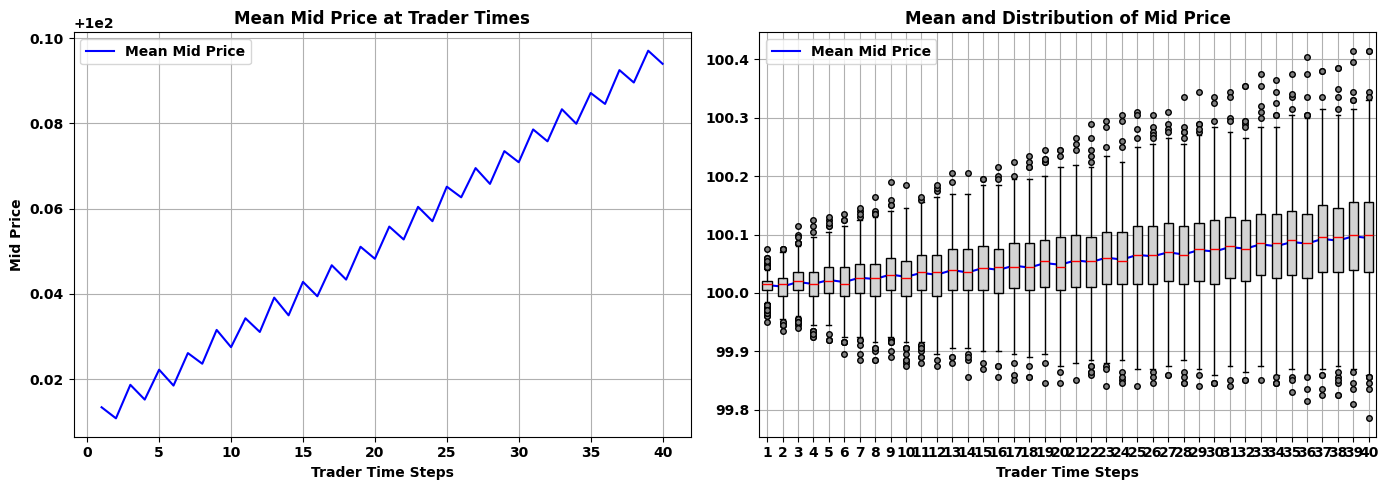

In [111]:
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/best_volume_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']

arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
x_vals = range(1, len(trader_times))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: mean mid price only
axs[0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0].set_title('Mean Mid Price at Trader Times')
axs[0].set_xlabel('Trader Time Steps')
axs[0].set_ylabel('Mid Price')
axs[0].grid()
axs[0].legend()

# Right plot: mean mid price + boxplots
axs[1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1].set_title('Mean and Distribution of Mid Price')
axs[1].set_xlabel('Trader Time Steps')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


## Front Load

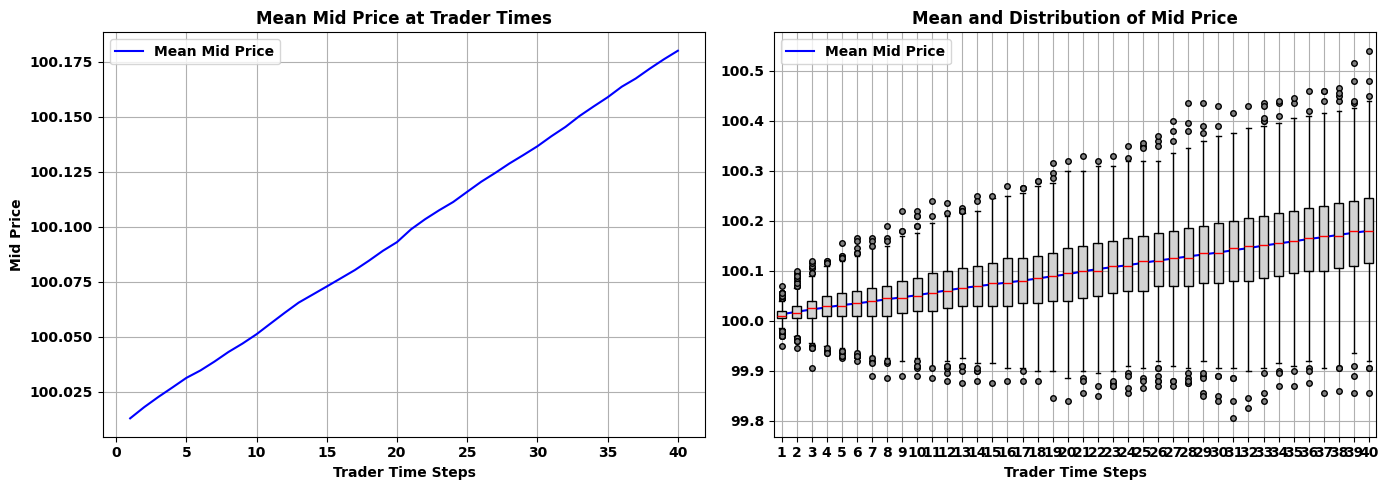

In [112]:
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/front_load_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']

arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
x_vals = range(1, len(trader_times))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: mean mid price only
axs[0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0].set_title('Mean Mid Price at Trader Times')
axs[0].set_xlabel('Trader Time Steps')
axs[0].set_ylabel('Mid Price')
axs[0].grid()
axs[0].legend()

# Right plot: mean mid price + boxplots
axs[1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1].set_title('Mean and Distribution of Mid Price')
axs[1].set_xlabel('Trader Time Steps')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()


## T = 100, TTS = 5, Inv=1000

In [126]:
T = 100
trader_time_step = 5
name_run = 'tts_5_inv_1000'

### Best Volume mod 2

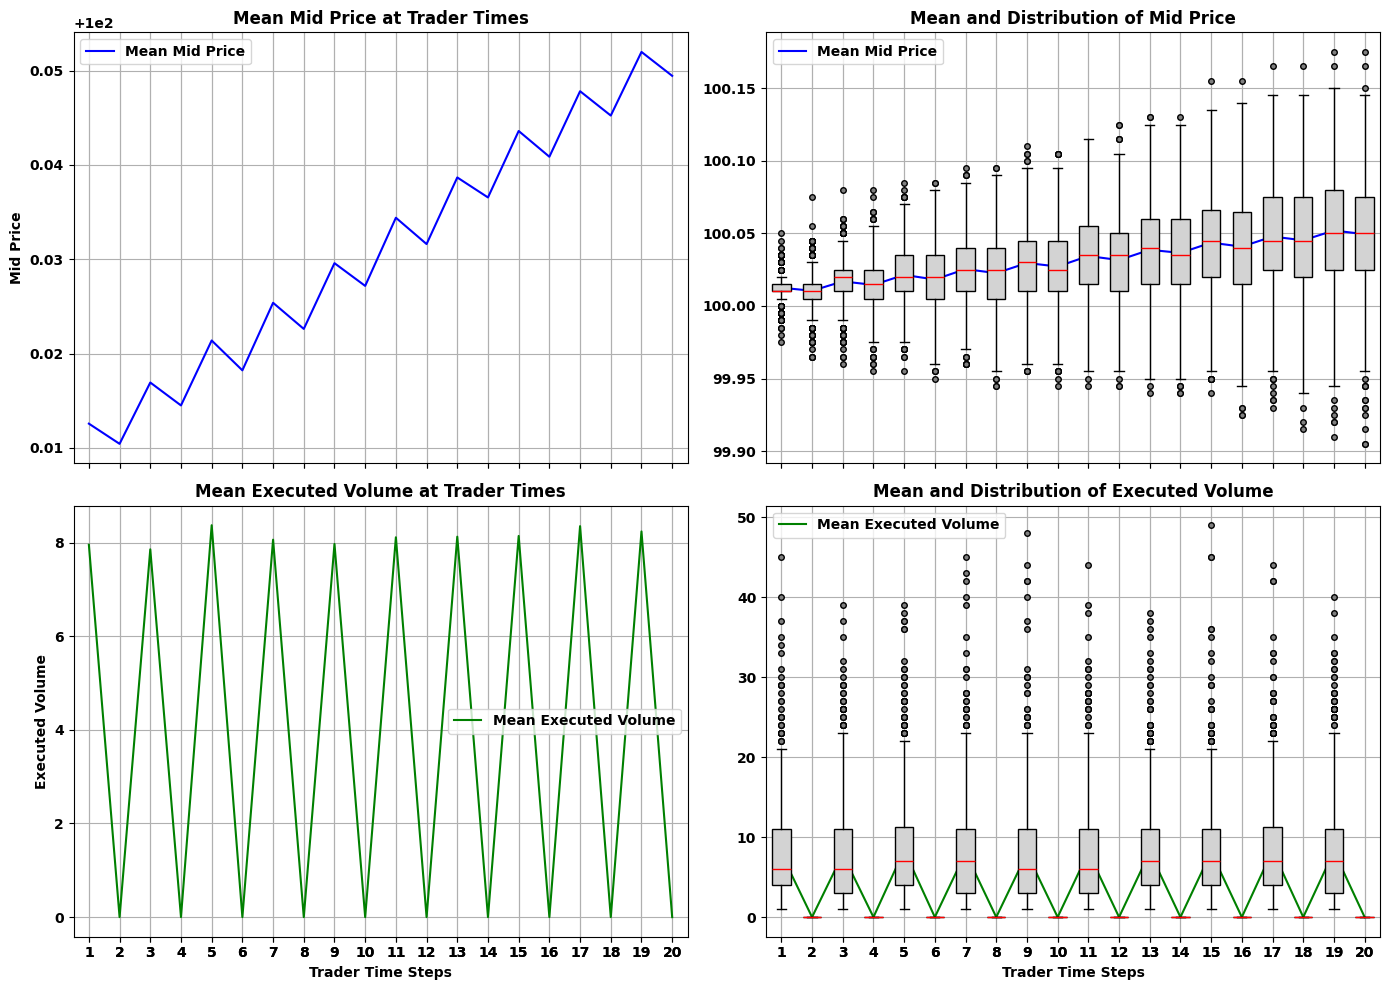

In [127]:
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/best_volume_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']
executed = dic['executed']

# Prepare arrays
arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
arr_executed = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)

for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

for i, execs in executed.items():
    arr_executed[i, :len(execs)] = execs

# X-axis values
x_vals = range(1, len(trader_times))

# Compute means
mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
mean_executed = np.nanmean(arr_executed, axis=0)

# Create 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# --- Mid Prices ---
# Top left: mean only
axs[0, 0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0, 0].set_title('Mean Mid Price at Trader Times')
axs[0, 0].set_ylabel('Mid Price')
axs[0, 0].grid()
axs[0, 0].legend()

# Top right: mean + boxplots
axs[0, 1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0, 1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[0, 1].set_title('Mean and Distribution of Mid Price')
axs[0, 1].grid()
axs[0, 1].legend()

# --- Executed Volume ---
# Bottom left: mean only
axs[1, 0].plot(x_vals, mean_executed, label='Mean Executed Volume', color='green')
axs[1, 0].set_title('Mean Executed Volume at Trader Times')
axs[1, 0].set_xlabel('Trader Time Steps')
axs[1, 0].set_ylabel('Executed Volume')
axs[1, 0].grid()
axs[1, 0].legend()

# Bottom right: mean + boxplots
axs[1, 1].plot(x_vals, mean_executed, label='Mean Executed Volume', color='green')
axs[1, 1].boxplot(
    [arr_executed[:, i][~np.isnan(arr_executed[:, i])] for i in range(arr_executed.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1, 1].set_title('Mean and Distribution of Executed Volume')
axs[1, 1].set_xlabel('Trader Time Steps')
axs[1, 1].grid()
axs[1, 1].legend()

plt.tight_layout()
plt.show()


## Front Load

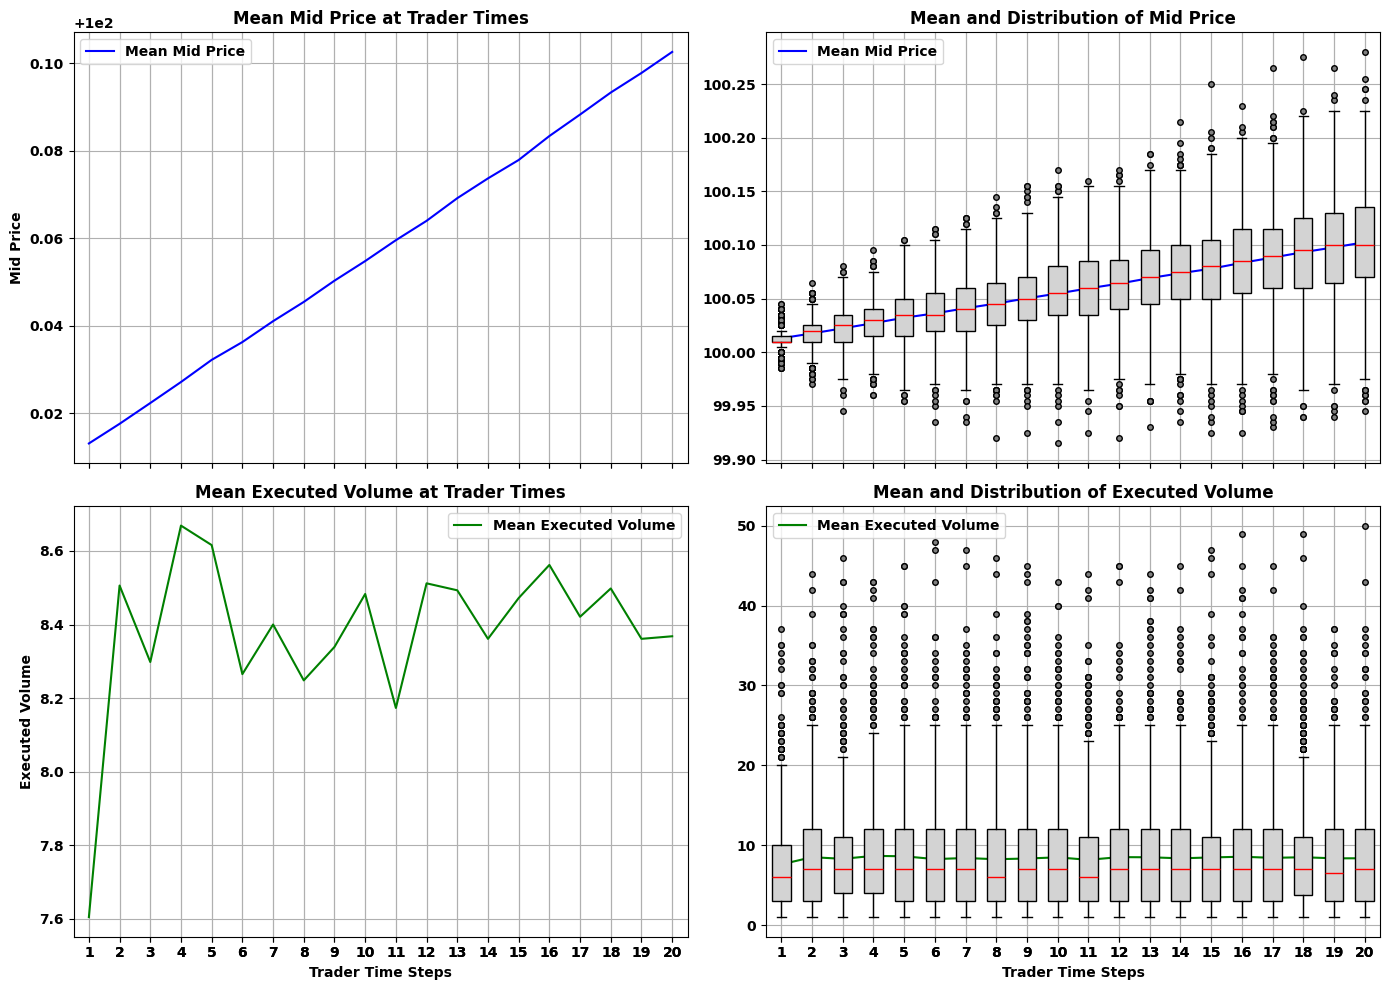

In [128]:
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/front_load_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']
executed = dic['executed']

# Prepare arrays
arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
arr_executed = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)

for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

for i, execs in executed.items():
    arr_executed[i, :len(execs)] = execs

# X-axis values
x_vals = range(1, len(trader_times))

# Compute means
mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
mean_executed = np.nanmean(arr_executed, axis=0)

# Create 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# --- Mid Prices ---
# Top left: mean only
axs[0, 0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0, 0].set_title('Mean Mid Price at Trader Times')
axs[0, 0].set_ylabel('Mid Price')
axs[0, 0].grid()
axs[0, 0].legend()

# Top right: mean + boxplots
axs[0, 1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0, 1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[0, 1].set_title('Mean and Distribution of Mid Price')
axs[0, 1].grid()
axs[0, 1].legend()

# --- Executed Volume ---
# Bottom left: mean only
axs[1, 0].plot(x_vals, mean_executed, label='Mean Executed Volume', color='green')
axs[1, 0].set_title('Mean Executed Volume at Trader Times')
axs[1, 0].set_xlabel('Trader Time Steps')
axs[1, 0].set_ylabel('Executed Volume')
axs[1, 0].grid()
axs[1, 0].legend()

# Bottom right: mean + boxplots
axs[1, 1].plot(x_vals, mean_executed, label='Mean Executed Volume', color='green')
axs[1, 1].boxplot(
    [arr_executed[:, i][~np.isnan(arr_executed[:, i])] for i in range(arr_executed.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1, 1].set_title('Mean and Distribution of Executed Volume')
axs[1, 1].set_xlabel('Trader Time Steps')
axs[1, 1].grid()
axs[1, 1].legend()

plt.tight_layout()
plt.show()


## T = 100, TTS = 3, Inv=1000

In [129]:
T = 100
trader_time_step = 3
name_run = 'tts_3_inv_1000'

### Best Volume mod 2

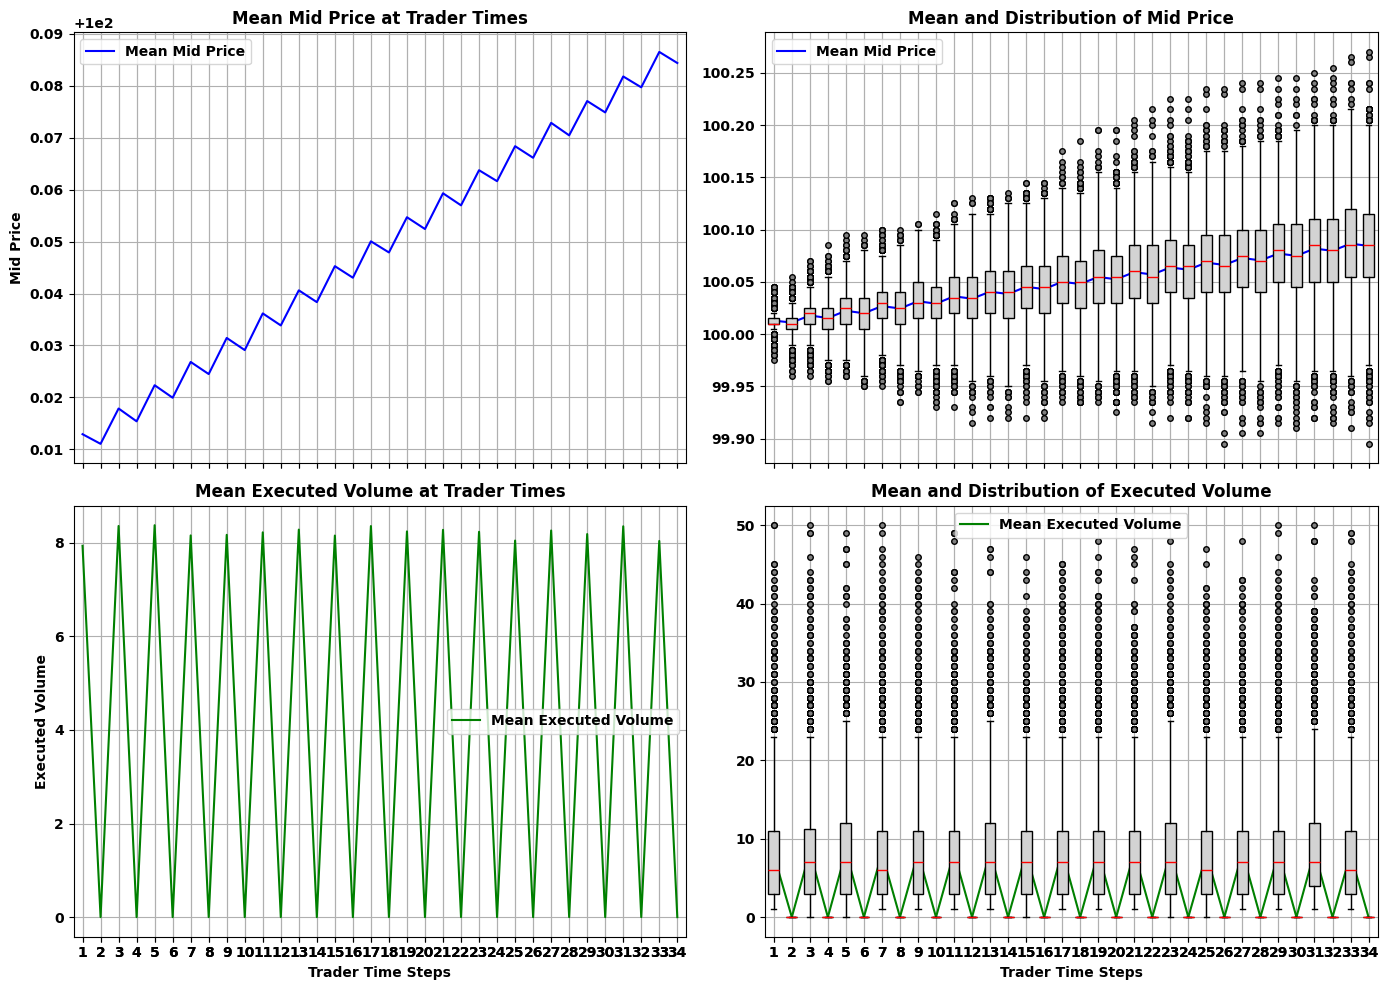

In [130]:
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/best_volume_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']
executed = dic['executed']

# Prepare arrays
arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
arr_executed = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)

for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

for i, execs in executed.items():
    arr_executed[i, :len(execs)] = execs

# X-axis values
x_vals = range(1, len(trader_times))

# Compute means
mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
mean_executed = np.nanmean(arr_executed, axis=0)

# Create 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# --- Mid Prices ---
# Top left: mean only
axs[0, 0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0, 0].set_title('Mean Mid Price at Trader Times')
axs[0, 0].set_ylabel('Mid Price')
axs[0, 0].grid()
axs[0, 0].legend()

# Top right: mean + boxplots
axs[0, 1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0, 1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[0, 1].set_title('Mean and Distribution of Mid Price')
axs[0, 1].grid()
axs[0, 1].legend()

# --- Executed Volume ---
# Bottom left: mean only
axs[1, 0].plot(x_vals, mean_executed, label='Mean Executed Volume', color='green')
axs[1, 0].set_title('Mean Executed Volume at Trader Times')
axs[1, 0].set_xlabel('Trader Time Steps')
axs[1, 0].set_ylabel('Executed Volume')
axs[1, 0].grid()
axs[1, 0].legend()

# Bottom right: mean + boxplots
axs[1, 1].plot(x_vals, mean_executed, label='Mean Executed Volume', color='green')
axs[1, 1].boxplot(
    [arr_executed[:, i][~np.isnan(arr_executed[:, i])] for i in range(arr_executed.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1, 1].set_title('Mean and Distribution of Executed Volume')
axs[1, 1].set_xlabel('Trader Time Steps')
axs[1, 1].grid()
axs[1, 1].legend()

plt.tight_layout()
plt.show()


## Front Load

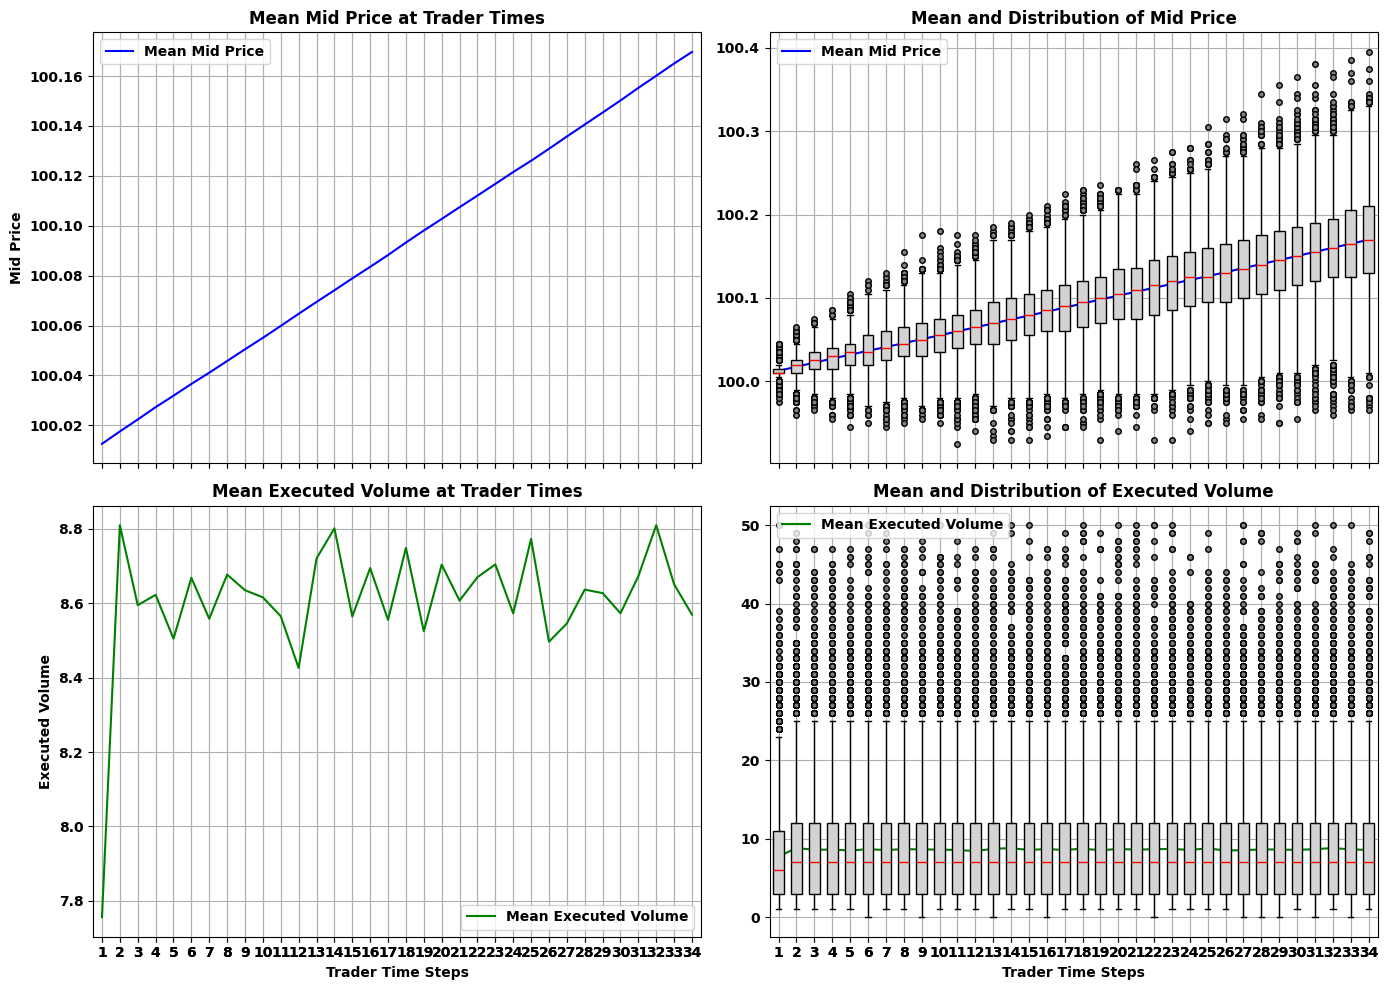

In [131]:
trader_times = np.arange(0, T + trader_time_step, trader_time_step)

with open(f'data_wandb/dictionaries/front_load_{name_run}.pkl', 'rb') as f:
    dic = pickle.load(f)

mid_prices_events = dic['mid_prices_events']
executed = dic['executed']

# Prepare arrays
arr_mid_prices = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)
arr_executed = np.full((len(mid_prices_events), len(trader_times) - 1), np.nan)

for i, mid_prices in mid_prices_events.items():
    arr_mid_prices[i, :len(mid_prices)] = mid_prices

for i, execs in executed.items():
    arr_executed[i, :len(execs)] = execs

# X-axis values
x_vals = range(1, len(trader_times))

# Compute means
mean_mid_prices = np.nanmean(arr_mid_prices, axis=0)
mean_executed = np.nanmean(arr_executed, axis=0)

# Create 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# --- Mid Prices ---
# Top left: mean only
axs[0, 0].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0, 0].set_title('Mean Mid Price at Trader Times')
axs[0, 0].set_ylabel('Mid Price')
axs[0, 0].grid()
axs[0, 0].legend()

# Top right: mean + boxplots
axs[0, 1].plot(x_vals, mean_mid_prices, label='Mean Mid Price', color='blue')
axs[0, 1].boxplot(
    [arr_mid_prices[:, i][~np.isnan(arr_mid_prices[:, i])] for i in range(arr_mid_prices.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[0, 1].set_title('Mean and Distribution of Mid Price')
axs[0, 1].grid()
axs[0, 1].legend()

# --- Executed Volume ---
# Bottom left: mean only
axs[1, 0].plot(x_vals, mean_executed, label='Mean Executed Volume', color='green')
axs[1, 0].set_title('Mean Executed Volume at Trader Times')
axs[1, 0].set_xlabel('Trader Time Steps')
axs[1, 0].set_ylabel('Executed Volume')
axs[1, 0].grid()
axs[1, 0].legend()

# Bottom right: mean + boxplots
axs[1, 1].plot(x_vals, mean_executed, label='Mean Executed Volume', color='green')
axs[1, 1].boxplot(
    [arr_executed[:, i][~np.isnan(arr_executed[:, i])] for i in range(arr_executed.shape[1])],
    positions=x_vals,
    widths=0.6,
    patch_artist=True,
    boxprops=dict(facecolor="lightgray", color="black"),
    medianprops=dict(color="red"),
    whiskerprops=dict(color="black"),
    capprops=dict(color="black"),
    flierprops=dict(markerfacecolor="gray", marker="o", markersize=4, linestyle="none")
)
axs[1, 1].set_title('Mean and Distribution of Executed Volume')
axs[1, 1].set_xlabel('Trader Time Steps')
axs[1, 1].grid()
axs[1, 1].legend()

plt.tight_layout()
plt.show()
